# Transfer Learning Study

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/neuromatch/
!ls

Mounted at /content/gdrive
/content/gdrive/MyDrive/neuromatch
Brain-Tumor-Classification-DataSet  experiment_01  results
checkpoint			    experiment_02


# Setup

In [ ]:
# imports
import os
import gc
import csv
import glob
import torch
import multiprocessing

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

In [ ]:
!nvidia-smi

Tue Aug 17 15:56:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##  Set random seed


 Executing `set_seed(seed=seed)` you are setting the seed


In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

##  Set device (GPU or CPU)


In [ ]:
# @title Set device (GPU or CPU)

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

### Random seeds

If you want to obtain reproducible results, it is a good practice to set seeds for the random number generators of the various libraries

In [ ]:
set_seed(seed=42)
device = set_device()

Random seed 42 has been set.
GPU is enabled in this notebook.


### Training hyperparameters

Here we set some general training hyperparameters such as the learning rate, batch size, etc. as well as other training options such as including data augmentation (`torchvision_transforms`).

In [ ]:
# hyper-parameters
use_cuda = torch.cuda.is_available()
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
batch_size = 64
max_epochs = 10  # Please change this to 200
max_epochs_target = 10
torchvision_transforms = False  # set True if you want use torchvision augmentations
SIZE = (224,224)
lr = 0.00001

result_folder = './results/'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

if not os.path.isdir('checkpoint'):
      os.mkdir('checkpoint')

# Batch Size=128 and IMGSIZE=224 out of memory

In [ ]:
#best_acc = 0  # best test accuracy
#start_epoch = 0  # start from epoch 0 or last checkpoint epoch
#batch_size = 128
#max_epochs = 25  # Please change this to 200
#max_epochs_target = 25
#base_learning_rate = 0.1
#torchvision_transforms = False  # set True if you want use torchvision augmentations
#SIZE = (224,224)
#lr = 0.0001

#Test Acc = 77.41

#best_acc = 0  # best test accuracy
#start_epoch = 0  # start from epoch 0 or last checkpoint epoch
#batch_size = 64
#max_epochs = 20  # Please change this to 200
#max_epochs_target = 20
#base_learning_rate = 0.1
#torchvision_transforms = False  # set True if you want use torchvision augmentations
#SIZE = (224,224)
#lr = 0.0001

#Test Acc = 76.39

#best_acc = 0  # best test accuracy
#start_epoch = 0  # start from epoch 0 or last checkpoint epoch
#batch_size = 256
#max_epochs = 30  # Please change this to 200
#max_epochs_target = 30
#base_learning_rate = 0.1
#torchvision_transforms = False  # set True if you want use torchvision augmentations
#SIZE = (224,224)
#lr = 0.0001

#Test Acc = 76.64

#best_acc = 0  # best test accuracy
#start_epoch = 0  # start from epoch 0 or last checkpoint epoch
#batch_size = 128
#max_epochs = 30  # Please change this to 200
#max_epochs_target = 30
#base_learning_rate = 0.1
#torchvision_transforms = False  # set True if you want use torchvision augmentations
#SIZE = (320,320)
#lr = 0.0001

#Test Acc = 75.58

---
# Data

## Source dataset

We will train the source model using CIFAR-100 data set from PyTorch, but with small tweaks we can get any other data we are interested in.

Note that the data set is normalised by substracted the mean and dividing by the standard deviation (pre-computed) of the training set. Also, if `torchvision_transforms` is `True`, data augmentation will be applied during training.

 Download and prepare Data


In [ ]:
# Download the dataset
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet.git

fatal: destination path 'Brain-Tumor-Classification-DataSet' already exists and is not an empty directory.


In [ ]:
print('==> Preparing data..')
def percentageSplit(full_dataset, percent = 0.0):
  test_size = int(percent * len(full_dataset))
  train_size = len(full_dataset) - set1_size
  final_dataset, _ = torch.utils.data.random_split(full_dataset, [test_size, train_size], )
  return final_dataset

# ImageNet normalizing
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# torchvision transforms
transform_train = transforms.Compose([])
if torchvision_transforms:
  #transform_train.transforms.append(transforms.RandomCrop(32, padding=4))
  #transform_train.transforms.append(transforms.RandomHorizontalFlip())
  transform_train.transforms.append(transforms.RandomRotation(30))

transform_train.transforms.append(transforms.Resize(SIZE))
transform_train.transforms.append(transforms.ToTensor())
transform_train.transforms.append(transforms.Normalize(mean, std))

transform_test = transforms.Compose([
    transforms.Resize(SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

trainset = torchvision.datasets.ImageFolder(
  root= 'Brain-Tumor-Classification-DataSet/Training', transform=transform_train)

testset = torchvision.datasets.ImageFolder(
  root='Brain-Tumor-Classification-DataSet/Testing', transform=transform_test)

==> Preparing data..


In [ ]:
trainset 

Dataset ImageFolder
    Number of datapoints: 2870
    Root location: Brain-Tumor-Classification-DataSet/Training
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
# print the size of dataset

print(len(trainset))

2870


In [ ]:
trainset.__dict__.keys()

dict_keys(['root', 'transform', 'target_transform', 'transforms', 'loader', 'extensions', 'classes', 'class_to_idx', 'samples', 'targets', 'imgs'])

## Data loaders

A dataloader is an optimized data iterator that provides functionality for efficient shuffling, transformation and batching of the data.

###  Dataloader


In [ ]:
##@title Dataloader
num_workers = multiprocessing.cpu_count()

print(f'----> number of workers: {num_workers}')

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

----> number of workers: 2


# Displaying Data

In [ ]:
# @title Plotting functions

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

def imshow(img):
  plt.figure(figsize=[20, 20])
  #unnormalize
  #img = img * torch.tensor(std).unsqueeze(dim=-1).unsqueeze(dim=-1)
  #img = img + torch.tensor(mean).unsqueeze(dim=-1).unsqueeze(dim=-1)
  img = UnNormalize(mean,std)(img)
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis(False)
  plt.show()

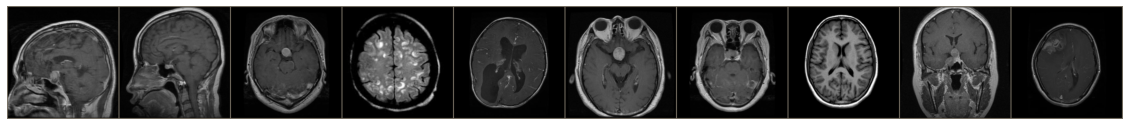

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(make_grid(images[:10], nrow = 10))

In [ ]:
images.shape

torch.Size([64, 3, 224, 224])

### Load pre-trained model

Load the checkpoint of the model previously trained on CIFAR-100

In [ ]:
classes_names = trainset.classes
print(classes_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [ ]:
#model = torchvision.models.vgg11(pretrained=True)

In [ ]:
#model.children()

In [ ]:
#ct = 0
#for child in model.children():  
#  ct += 1
#  print(ct)
#  print(child.state_dict().keys())
#  print('test')

In [ ]:
#model.features[0].bias.require_grad = False

In [ ]:
# Print model's state_dict
#print("Model's state_dict:")
#for param_tensor in model.state_dict():
#    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [ ]:
#model

# Fine Tuning

### Freeze model parameters

In transfer learning, we usually do not re-train all the weights of the model, but only a subset of them, for instance the last layer. Here we first _freeze_ all the parameters of the model, and we will _unfreeze_ one layer below.

In [ ]:
# Freeze the model parameters, you can also freeze some layers only
#for param in model.parameters():
#  param.requires_grad = False

In [ ]:
#model.classifier[6]

In [ ]:
# Fine tunning
# fc is the name of the last fully connected layer, so we can replace it
#num_ftrs = model.classifier[6].in_features
#model.classifier[6] = nn.Linear(num_ftrs, len(classes_names))

#model.to(device)

# define the loss function
#criterion = nn.CrossEntropyLoss()

# define the optimizer
#optimizer = torch.optim.SGD(
#    model.classifier[6].parameters(),
#    lr=lr,
#    momentum=0.9,
#    weight_decay=1e-4,
#)

In [ ]:
# from torch.optim import lr_scheduler

In [ ]:
pretrained = torchvision.models.vgg19_bn(pretrained=True) #TODO: change the network
pretrained.classifier = nn.Identity()
class MyVGG11(nn.Module):
    def __init__(self, my_pretrained_model):
        super(MyVGG11, self).__init__()
        self.pretrained = nn.Sequential(my_pretrained_model)
        # self.my_new_layers = nn.Sequential(nn.ReLU(),
        #                                    nn.Linear(25088, 4),
        #                                    nn.LogSoftmax())
        self.my_new_layers = nn.Sequential(nn.ReLU(),
                                    nn.Linear(25088, 128),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.5),
                                    nn.Linear(128, 4),
                                    nn.LogSoftmax())
    
    def forward(self, x):
        x = self.pretrained(x)
        x = self.my_new_layers(x)
        return x

model = MyVGG11(my_pretrained_model=pretrained)

model.to(device)

# define the loss function
criterion = nn.CrossEntropyLoss()

#for param in model.pretrained.parameters():
#  param.requires_grad = False

#for i in [16, 18]:
#  model.pretrained[0].features[i].weight.requires_grad = True
#  model.pretrained[0].features[i].bias.requires_grad = True

# define the optimizer
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr,
    momentum=0.9,
    weight_decay=1e-4
)

# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [ ]:
list(model.children())[0]

Sequential(
  (0): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [ ]:
model

MyVGG11(
  (pretrained): Sequential(
    (0): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU(inplace=True)
        (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (10): ReLU(inplace=True)
        (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (12): BatchNorm2d(256, eps=1e-05, mo

#### Check number of parameters

We can calculate the number of total parameters and the number of trainable parameters, that is those that will be updated during training. Since we have freezed most of the parameters, the number of training parameters should be much smaller.

In [ ]:
#Total Parameters: 128782724 Trainable parameters:  16388

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Total Parameters:', total_params, 'Trainable parameters: ', trainable_total_params)

Total Parameters: 23247300 Trainable parameters:  23247300


### Train the target model

In [ ]:
# #@title Auxiliar Functions
# # checkpoint & adjust_learning_rate
# def checkpoint(model, acc, epoch, outModelName):
#   # Save checkpoint.
#   print('Saving..')
#   state = {
#       'state_dict': model.state_dict(),
#       'acc': acc,
#       'epoch': epoch,
#       'rng_state': torch.get_rng_state()
#   }
#   if not os.path.isdir('checkpoint'):
#       os.mkdir('checkpoint')
#   torch.save(state, f'./checkpoint/{outModelName}.t7')

# def adjust_learning_rate(optimizer, epoch):
#   """decrease the learning rate at 100 and 150 epoch"""
#   lr = base_learning_rate
#   if epoch <= 9 and lr > 0.1:
#     # warm-up training for large minibatch
#     lr = 0.1 + (base_learning_rate - 0.1) * epoch / 10.
#   if epoch >= 100:
#     lr /= 10
#   if epoch >= 150:
#     lr /= 10
#   for param_group in optimizer.param_groups:
#     param_group['lr'] = lr

In [ ]:
# Training & Test functions

def train(net, epoch, use_cuda=True):
  print('\nEpoch: %d' % epoch)
  net.train() # set the model in training mode
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (inputs, targets) in enumerate(trainloader):
    if use_cuda:
      inputs, targets = inputs.cuda(), targets.cuda()

    optimizer.zero_grad()
    inputs, targets = Variable(inputs), Variable(targets) # Why here is used Variable. Is it needed?
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    
    #print('new iteration')
    #print(train_loss)
    #print(loss.item())
    train_loss += loss.item() # is the code getting the avg loss since the first iteration batch?
    #print('change')
    #print(train_loss)
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += predicted.eq(targets.data).cpu().sum()

    if batch_idx % 2 == 0:
      print("Train ",batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

  print('final loss')    
  print(train_loss/batch_idx, 100)
  return (train_loss/batch_idx, 100.*correct/total)


def test(net, epoch, outModelName, use_cuda=True):
  global best_acc
  net.eval() # set the model in eval mode
  test_loss, correct, total = 0, 0, 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
      if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()

      outputs = net(inputs)
      loss = criterion(outputs, targets)

      test_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += predicted.eq(targets.data).cpu().sum()

      if batch_idx % 2 == 0:
        print("Test ", batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

  # Save checkpoint.
  acc = 100.*correct/total
  if acc > best_acc:
    best_acc = acc
    #checkpoint(net, acc, epoch, outModelName)
    torch.save(model, f'./checkpoint/{outModelName}_acc({str(acc.item()).replace(".","-")})_epoch({epoch}).pt')

  return (test_loss/batch_idx, 100.*correct/total)

In [ ]:
outModelName = 'VGG19_bn_dropout_test_01' # TODO: Change the name of the experiment
logname = result_folder + model.__class__.__name__ + f'_{outModelName}.csv'

if not os.path.exists(logname):
  with open(logname, 'w') as logfile:
    logwriter = csv.writer(logfile, delimiter=',')
    logwriter.writerow(['epoch', 'train loss', 'train acc', 'test loss', 'test acc'])#, 'lr'])

for epoch in range(start_epoch, max_epochs_target):
  #adjust_learning_rate(optimizer, epoch)
  train_loss, train_acc = train(model, epoch, use_cuda=use_cuda)
  test_loss, test_acc = test(model, epoch, outModelName, use_cuda=use_cuda)
  #scheduler.step()
  #print(scheduler.get_last_lr())
  with open(logname, 'a') as logfile:
    logwriter = csv.writer(logfile, delimiter=',')
    logwriter.writerow([epoch, train_loss, train_acc.item(), test_loss, test_acc.item()])#, scheduler.get_last_lr()[0]])
  print(f'Epoch: {epoch} | train acc: {train_acc} | test acc: {test_acc}')


Epoch: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train  0 45 Loss: 1.417 | Acc: 15.625% (10/64)
Train  2 45 Loss: 1.417 | Acc: 18.750% (36/192)
Train  4 45 Loss: 1.420 | Acc: 16.875% (54/320)
Train  6 45 Loss: 1.414 | Acc: 18.080% (81/448)
Train  8 45 Loss: 1.414 | Acc: 18.229% (105/576)
Train  10 45 Loss: 1.412 | Acc: 18.750% (132/704)
Train  12 45 Loss: 1.412 | Acc: 18.870% (157/832)
Train  14 45 Loss: 1.412 | Acc: 18.438% (177/960)
Train  16 45 Loss: 1.413 | Acc: 18.750% (204/1088)
Train  18 45 Loss: 1.412 | Acc: 18.586% (226/1216)
Train  20 45 Loss: 1.412 | Acc: 18.973% (255/1344)
Train  22 45 Loss: 1.409 | Acc: 19.905% (293/1472)
Train  24 45 Loss: 1.408 | Acc: 20.188% (323/1600)
Train  26 45 Loss: 1.409 | Acc: 19.965% (345/1728)
Train  28 45 Loss: 1.408 | Acc: 19.989% (371/1856)
Train  30 45 Loss: 1.408 | Acc: 20.212% (401/1984)
Train  32 45 Loss: 1.407 | Acc: 20.407% (431/2112)
Train  34 45 Loss: 1.408 | Acc: 20.268% (454/2240)
Train  36 45 Loss: 1.408 | Acc: 20.186% (478/2368)
Train  38 45 Loss: 1.407 | Acc: 20.673% (516/2496

In [ ]:
#results = results.iloc[40:]

#torch.save({
#            'epoch': EPOCH,
#            'model_state_dict': net.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': LOSS,
#            }, PATH)
#torch.load(PATH)

## Plot results

In [ ]:
def plot_comparison_best(csv_dir, figureName):

  list_files = sorted(os.listdir(csv_dir))

  categories = np.arange(len(list_files))  
  #colormap = np.array(['r', 'g', 'b'])
  norm = plt.Normalize()
  colormap = plt.cm.brg(norm(categories))



  label_list = [f.split("_")[0] for f in list_files]
  best_acc_train = []
  best_loss_train = []
  best_acc_test = []
  best_loss_test = []

  for i, filename in enumerate(list_files):
    results = pd.read_csv(os.path.join(csv_dir, filename))
    best_acc_train.append(results['train acc'].values[-1])
    best_loss_train.append(results['train loss'].values[-1])
    best_acc_test.append(results['test acc'].values[-1])
    best_loss_test.append(results['test loss'].values[-1])


  plt.style.use('fivethirtyeight')
  fig, (ax1, ax2) = plt.subplots(figsize=(16,8),nrows=1, ncols=2, sharex=True, sharey=False)

  ax1.scatter(label_list, best_acc_train, marker='s', label = "train", c=colormap[categories])
  ax1.scatter(label_list, best_acc_test, marker='o', label = "test", c=colormap[categories])
  ax1.legend()
  ax1.set_ylim([0,100])
  ax1.set(xlabel="Models", ylabel="Best Accuracy Score")
  ax2.scatter(label_list, best_loss_train, marker='s', label = "train", c=colormap[categories])
  ax2.scatter(label_list, best_loss_test, marker='o', label = "test", c=colormap[categories])
  ax2.legend()
  ax2.set(xlabel="Models", ylabel="Best CrossEntrpoy Loss")

  fig.savefig(f'./results/{figureName}.png')
  plt.show()


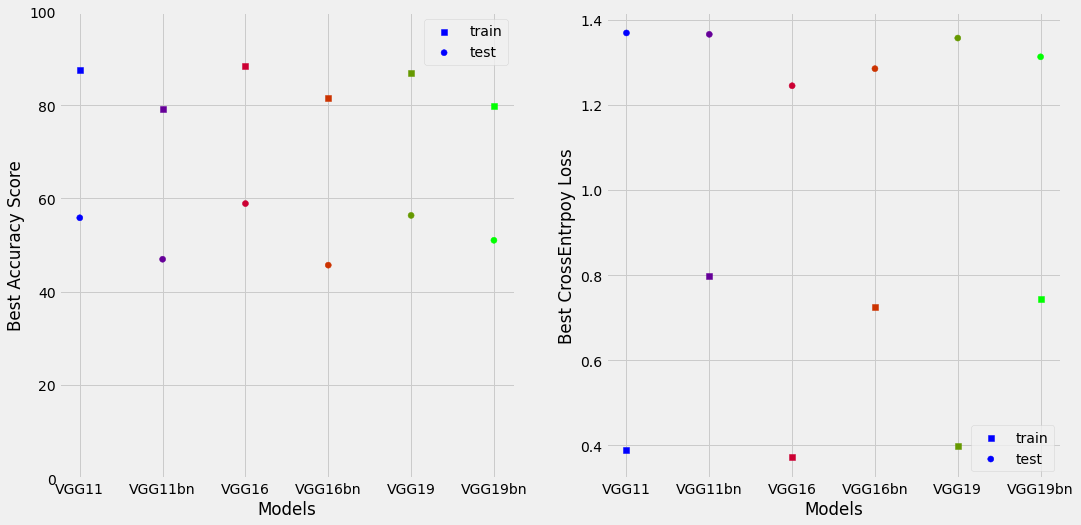

In [ ]:
csv_dir = "experiment_01"
figureName = f'comparison_best_{csv_dir}'

plot_comparison_best(csv_dir, figureName)

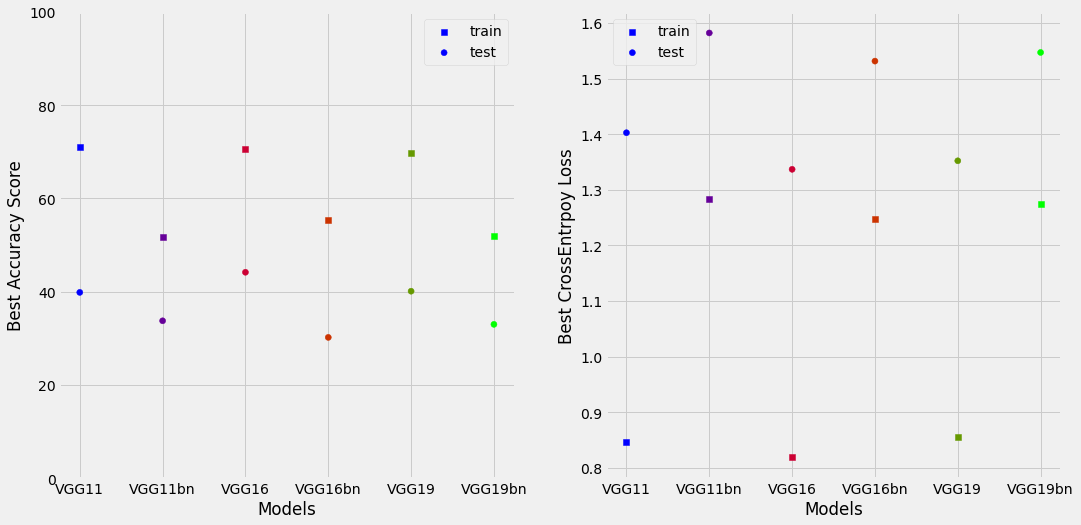

In [ ]:
csv_dir = "experiment_02"
figureName = f'comparison_best_{csv_dir}'

plot_comparison_best(csv_dir, figureName)

In [ ]:
def plot_training(csv_dir, figureName):

  list_files = sorted(os.listdir(csv_dir))

  label_list = [f.split("_")[0] for f in list_files]

  categories = np.arange(len(list_files))  
  #colormap = np.array(['r', 'g', 'b'])
  norm = plt.Normalize()
  colormap = plt.cm.viridis(norm(categories))


  plt.style.use('fivethirtyeight')
  fig, (ax1, ax2) = plt.subplots(figsize=(16,8),nrows=1, ncols=2, sharex=True, sharey=False)

  for i, filename in enumerate(list_files):
    results = pd.read_csv(os.path.join(csv_dir, filename))

    p1 = ax1.plot(results['epoch'].values, results['train acc'].values, '-', color = colormap[i], label=label_list[i] + ' train', marker='s', lw=3)
    p2 = ax1.plot(results['epoch'].values, results['test acc'].values, '--', color = colormap[i], label=label_list[i] + ' test', marker='o', lw=3)
    ax1.legend(ncol=2)
    ax1.set_ylim([0,100])
    ax1.set(xlabel="Epochs", ylabel="Accuracy Score")
    ax2.plot(results['epoch'].values, results['train loss'].values, '-', color = colormap[i],label=label_list[i] + ' train', marker='s', lw=3)
    ax2.plot(results['epoch'].values, results['test loss'].values, '--', color = colormap[i], label=label_list[i] + ' test', marker='o', lw=3)
    ax2.legend(ncol=2)
    ax2.set(xlabel="Epochs", ylabel="CrossEntrpoy Loss")

  fig.savefig(f'./results/{figureName}.png')
  plt.show()

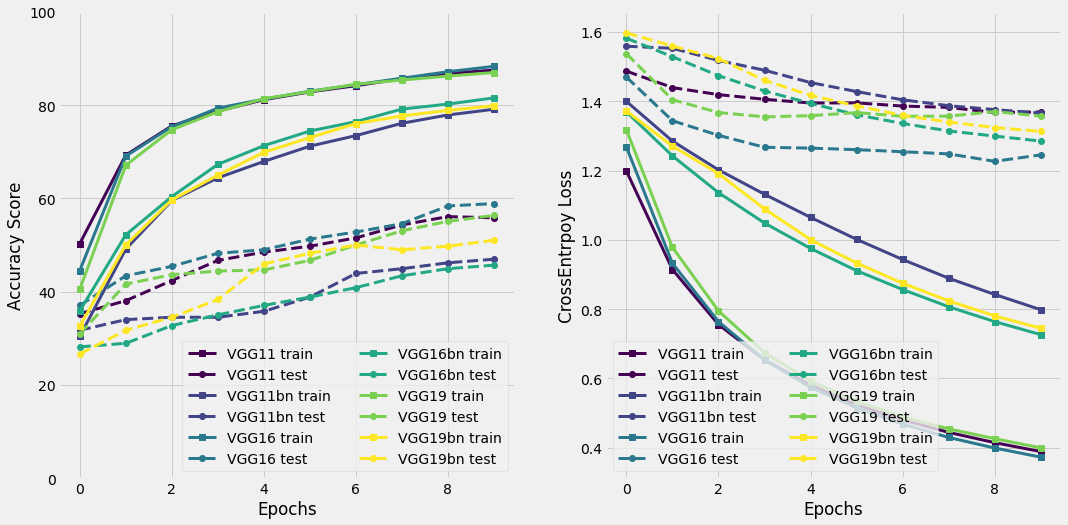

In [ ]:
csv_dir = "experiment_01"
figureName = f'comparison_{csv_dir}'

plot_training(csv_dir, figureName)

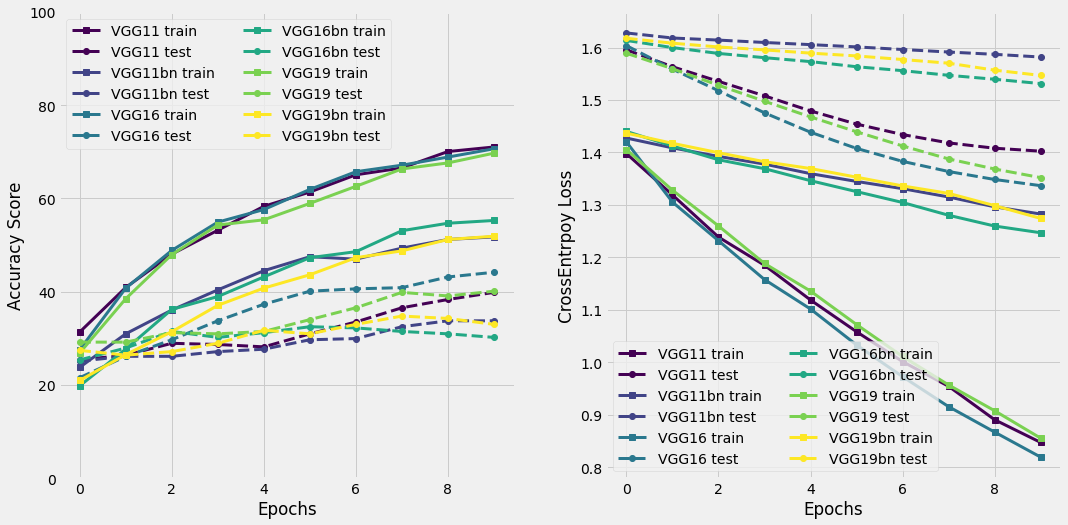

In [ ]:
csv_dir = "experiment_02"
figureName = f'comparison_{csv_dir}'

plot_training(csv_dir, figureName)

In [ ]:
# title plot results
results = pd.read_csv(f'./results/MyVGG11_{outModelName}.csv', sep =',')
results.head()

,epoch,train loss,train acc,test loss,test acc
0,0,1.436819,20.975609,1.617719,27.411167
1,1,1.417509,26.515680,1.608328,26.395939
2,2,1.399546,31.428572,1.601170,27.157360
3,3,1.382418,37.073170,1.595564,28.934010
4,4,1.369412,40.766552,1.589400,31.725889


In [ ]:
results

,epoch,train loss,train acc,test loss,test acc
0,0,1.436819,20.975609,1.617719,27.411167
1,1,1.417509,26.515680,1.608328,26.395939
2,2,1.399546,31.428572,1.601170,27.157360
3,3,1.382418,37.073170,1.595564,28.934010
4,4,1.369412,40.766552,1.589400,31.725889
5,5,1.352912,43.623692,1.584045,30.964466
6,6,1.336272,47.282230,1.577228,32.994923
7,7,1.322060,48.745644,1.570215,34.771572
8,8,1.298690,51.184669,1.556946,34.263958
9,9,1.274358,51.881535,1.546889,32.994923


In [ ]:
#scheduler.get_last_lr()[0]

In [ ]:
#results['lr'][0]

In [ ]:
train_accuracy = results['train acc'].values
test_accuracy = results['test acc'].values
train_loss = results['train loss'].values
test_loss = results['test loss'].values

print(f'Average Accuracy over {max_epochs_target} epochs:', sum(test_accuracy)//len(test_accuracy))
print(f'best accuraccy over {max_epochs_target} epochs:', max(test_accuracy))

Average Accuracy over 10 epochs: 30.0
best accuraccy over 10 epochs: 34.77157211303711


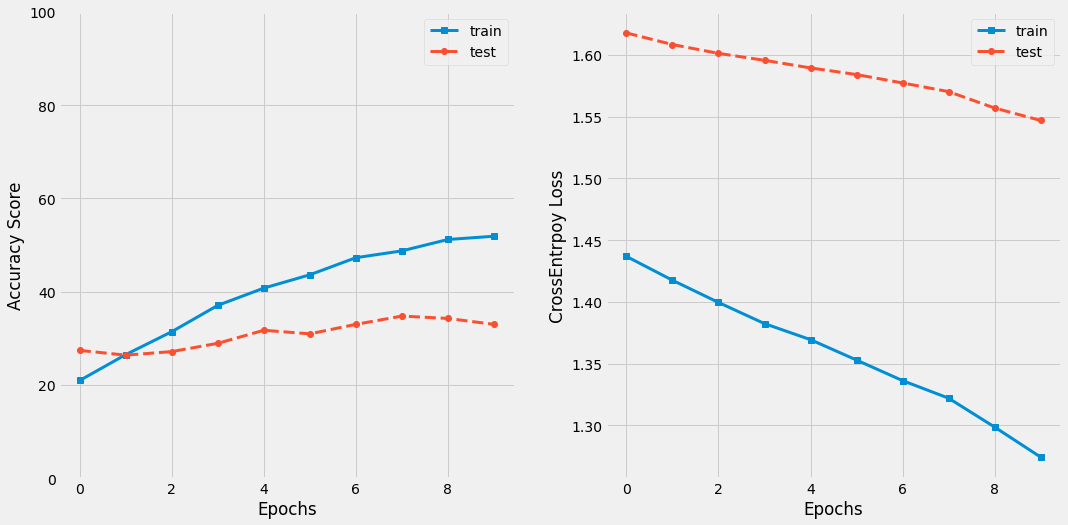

In [ ]:
plt.style.use('fivethirtyeight')
figureName = 'result'

fig, (ax1, ax2) = plt.subplots(figsize=(16,8),nrows=1, ncols=2, sharex=True, sharey=False)
ax1.plot(results['epoch'].values, train_accuracy, '-', label='train', marker='s', lw=3)
ax1.plot(results['epoch'].values, test_accuracy, '--', label='test', marker='o', lw=3)
ax1.legend()
ax1.set_ylim([0,100])
ax1.set(xlabel="Epochs", ylabel="Accuracy Score")
ax2.plot(results['epoch'].values, train_loss, '-', label='train', marker='s', lw=3)
ax2.plot(results['epoch'].values, test_loss, '--', label='test', marker='o', lw=3)
ax2.legend()
ax2.set(xlabel="Epochs", ylabel="CrossEntrpoy Loss")
fig.savefig(f'./results/{figureName}.png')
plt.show()